# Стохастический анализ (2025)
# Домашнее Задание 4

Шмелева Анна

Оценка: ?? из 100


Задачи: ?? из 

Ноутбук: ?? из 40


Дедлайн: 20 июня, 23:59МСК

Решённый ноутбук нужно засабмитить в класрум курса

Пожалуйста, называйте файл(ы) в формате <Имя>HW4.pdf или <Имя>HW4.ipynb. Например, KaledinHW4.pdf и KaledinHW4.ipynb.

In [ ]:
#all imports here, pls
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

В этом ноутбуке мы более плотно поисследуем некоторые физические явления в микро- и макромасштабе с помощью численных методов, а также ещё посмотрим на MCMC в действии.

## Диффузии (35 баллов)


### (20 баллов) Алгоритмы семплирования

Мы будем исследовать две цепи: от алгоритма ULA и алгоритма MALA. Для реализации этих методов вам прежде всего понадобится метод Эйлера (используйте свою реализацию или дополните реализацию ниже).

In [2]:
class SDESolver:
    
    def __init__(self, b, sigma):
        self.b = b 
        self.sigma = sigma
    
    def step(self, x, t, tnext):
        """One integration step

        Raises:
            NotImplementedError: if not implemented
        """        
        raise NotImplementedError
    
    #added returnLast to not store everything
    #added kwargs to send additional arguments to step through solve
    def solve(self, x0, ts, returnLast=False, loaderLabel="Solving....", **kwargs):
        """Computes the solution on the given grid ts with x0 as initial condition

        Args:
            x0 float[]: initial condition (N,d,) or (d,)
            ts float[]: time grid (T,)
            tIds float[]: optional, ids in the dense time grid (sent through kwargs, needed for experiments)
        Returns:
            xs float[]: approximated solution (N,d,T) at points ts
        """
        try:
            if(len(x0.shape)==1):
                x0 = x0[None, :]
        except:
            #a number?
            x0 = np.ones([1,1])*x0
            
        
        if(returnLast):
            xs = x0    
        else:            
            xs = np.zeros([x0.shape[0], x0.shape[1], len(ts)])
            xs[...,0] = x0
        
        print(loaderLabel)
        for i in tqdm.tqdm(np.arange(1,len(ts))):
            if(returnLast):
                xs = self.step(xs,ts[i-1],ts[i],**kwargs)
            else:
                xs[...,i] = self.step(xs[...,i-1],ts[i-1],ts[i],**kwargs)
        
        return xs
    
class EulerSolver(SDESolver):
    
    def __init__(self,b,sigma):
        super(EulerSolver, self).__init__(b,sigma)
        
    def step(self, x, t, tnext,**kwargs):
        """Makes Euler step

        Args:
            x float[]: previous point (N,d)
            t float: previous time
            tnext float: next time
        """            
        #b (N,d)  x (N,d)   sigma (N,d,d)
        #NEW!! improved to handle sigma as matrix
        if(x.ndim==1): #in case we still got (d,)
            x = x[None,:]
        
        dt = tnext - t
        drift = self.b(t, x)
        diffusion = self.sigma(t, x)

        dw = np.random.standard_normal(size=x.shape)[:,None,:]*np.sqrt(dt)

        res = x + drift * dt + (diffusion * dw).sum(axis=-1)
        return res

Ещё нам понадобится обёртка для семплера, семплер ULA и семплер MALA.

In [3]:
class Sampler:
    
    def __init__(self):
        pass
    
    def sample(self, N):
        """Samles N points

        Args:
            N (int): number of points to sample

        Raises:
            NotImplementedError: since needs override
        """        
        raise NotImplementedError

#for simplicity, a start sampler
class ConstSampler(Sampler):
    
    def __init__(self, const):
        '''
        Returns a const vector const (d,)
        '''
        self.const = const
        
    def sample(self,N):
        return self.const[None,:]*np.ones([N,1])
    
    
class GaussianSampler(Sampler):
    
    def __init__(self, mu, cov):
        self.mu = mu
        self.cov = cov
    
    def sample(self,N):
        return np.random.multivariate_normal(self.mu,self.cov, size=(N,))
    
class UniformSampler(Sampler):
    
    def __init__(self, left, right):
        self.left = left
        self.right = right
    
    def sample(self,N):
        return np.random.uniform(size=(N,self.left.shape[0]))*(self.right - self.left) + (self.right + self.left)/2
    
    
class ULASampler(Sampler):
    
    def __init__(self, gradLog, startSampler, delta=0.01):
        """
        Args:
            gradLog functionHandler: function mapping R^d tp R^d, gradient of the logarithm
            delta float: discrete time step, defaults to 0.01
            startSampler functionHandler: maps int N to a set of N samples
        """        
        super(ULASampler,self).__init__()
        self.gradLog = gradLog
        self.delta = delta
        self.startSampler = startSampler
        
        #pass t because of solver
        def sigg(t,x):
            # return np.sqrt(2)*np.eye(x.shape[1])[None,...] * np.ones([x.shape[0],x.shape[1],x.shape[1]])
            return np.sqrt(2) * np.eye(x.shape[1]) * np.ones([x.shape[0],x.shape[1],x.shape[1]])
        self.solver = EulerSolver(self.gradLog,sigma=sigg)
        
    def sample(self, N, burnIn=20000, parallelChains=False):
        """Samles N points

        Args:
            N (int): number of points to sample
            burnIn (int): number of samples to burn before sampling

        Raises:
            NotImplementedError: since needs override
        """        
        Tburned = burnIn*self.delta
        if(parallelChains):
            #CASE of parallel sampling: run N chains in parallel, collect the last state
            startPoints = self.startSampler.sample(N)
            result = startPoints
            print("Sampling...")
            for i in tqdm.tqdm(range(burnIn)):
                result = self._odeStep(result)
        else:
            #CASE of sequential sampling: wait and then collect, one trajectory
            startPoints = self.startSampler.sample(1)
            burned = startPoints
            for _ in tqdm.tqdm(range(burnIn), desc="Burning"):
                burned = self._odeStep(burned)
            result = np.zeros([N,startPoints.shape[-1]])
            result[0,:]=burned
            print("Sampling...")
            for i in tqdm.tqdm(np.arange(1,N), desc="Sampling"):
                result[i,:] = self._odeStep(result[i-1,:][None,:])[0] #result (N,d) is the sample of N observations  

        return result

    def _odeStep(self,x):
        #one step of the solver
        return self.solver.step(x,0,self.delta)
         
    

Проверим теперь ULASampler на простом примере семплирования из $N(1,1)$. Постройте диффузию Ланжевена для семплирования из этого распределения.

РЕШЕНИЕ ТУТ 

Положим $\xi$ ~ $N(1, 1)$, тогда
$$ p_\xi (t) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(t-1)^2}{2}\right) $$

$$ \nabla (\log p_{\xi} t) dt = - \frac{(t-1)^2}{2} dt - log(\sqrt{2\pi})dt = 1-t$$

$$ dX_t = \nabla (\log p_{\xi} X_t) dt + (\sqrt{2}) dW_t = (1-X_t)dt + (\sqrt{2}) dW_t $$

In [4]:
#pass t because of solver
def gradLog(t,x):
    return -(x-1)

startSampler = ConstSampler(np.zeros([1]))
delta = 0.001
ulaSampler = ULASampler(gradLog,startSampler,delta)

In [5]:
sampleParallel = ulaSampler.sample(10000,burnIn=100000, parallelChains=True)
sampleSequential = ulaSampler.sample(10000,burnIn=100000, parallelChains=False)
print(sampleParallel.shape,sampleSequential.shape)

Sampling...


Burning: 100%|██████████| 100000/100000 [00:02<00:00, 34989.30it/s]


Sampling...


Sampling: 100%|██████████| 9999/9999 [00:00<00:00, 32691.27it/s]

(10000, 1) (10000, 1)


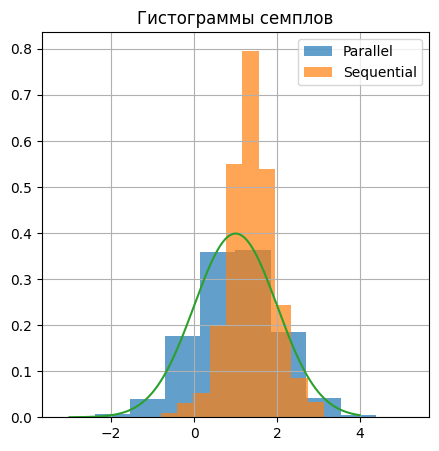

In [6]:
f, ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Гистограммы семплов")
ax.hist(sampleParallel[:,0], alpha=0.7,density=True,)
ax.hist(sampleSequential[:,0], alpha=0.7,density=True)
ax.legend(["Parallel","Sequential"])

xx = np.arange(-3,4,0.01)
normPDF = spstats.norm.pdf(xx-1)
ax.plot(xx,normPDF)

У Sequential-версии распределение немного отличается в силу коррелированности семплов, но у обеих версий примерно в одном месте находятся мода и матожидание.

Теперь алгоритм MALA. Он несильно отличается от ULA, но нам понадобится дополнительно знание плотности с точностью до константы нормировки.

Ещё нужно явно выписать пропоузал, он НЕсимметричный и его надо вычислять. Нужно с точностью до нормировочной константы(она сократится) вычислить

РЕШЕНИЕ ТУТ

$q(X' \vert X_t)$ ~
$\mathcal{N}\!(X_t + \Delta t_k\nabla\log\pi(X_t), 2\Delta t_k I)$

$$
q(X' \vert X_t) =
\frac{1}{(4\pi\Delta t_k)^{d/2}}
\exp\!\left(
-\tfrac{1}{4\Delta t_k}\,\lVert X' - X_t - \Delta t_k\,\nabla\ln\pi(X_t)\rVert^2
\right),
$$

$q(X_t \vert X')$ ~ $\mathcal{N}\!(X' + \Delta t_k\nabla\log\pi(X'), 2\Delta t_k I)$

$$
q(X' \vert X_t) =
\frac{1}{(4\pi\Delta t_k)^{d/2}}
\exp\!\left(
-\tfrac{1}{4\Delta t_k}\,\lVert X_t - X' - \Delta t_k\,\nabla\ln\pi(X')\rVert^2
\right),
$$

Запишите формулы для плотностей пропоузала в ULA ниже (это важно! потом может быть очень сложно искать ошибку).

In [ ]:
class MALASampler(ULASampler):
    
    def __init__(self, gradLog, startSampler, density, delta=0.01):
        """
        Args:
            gradLog functionHandler: function mapping R^d tp R^d, gradient of the logarithm
            delta float: discrete time step, defaults to 0.01
            startSampler functionHandler: maps int N to a set of N samples
            density functionHandler: maps R^d tp R, density function up to normalization constant
        """        
        super(MALASampler,self).__init__(gradLog, startSampler, delta)
        self.density = density
        
    def sample(self, N, burnIn=20000, parallelChains=False):
        """Samles N points

        Args:
            N (int): number of points to sample
            burnIn (int): number of samples to burn before sampling

        Raises:
            NotImplementedError: since needs override
        """        

        if(parallelChains):
            #CASE of parallel sampling: run N chains in parallel, collect the last state
            startPoints = self.startSampler.sample(N)
            print("Burning...")
            res = startPoints
            for i in tqdm.tqdm(np.arange(burnIn)):
                res = self._MHStep(res)
                pass
            print("Sampling...")
            result = res
        else:
            #CASE of sequential sampling: wait and then collect, one trajectory
            startPoints = self.startSampler.sample(1)
            res = startPoints
            print("Burning...")
            for i in tqdm.tqdm(np.arange(burnIn)):
                res = self._MHStep(res)
            #make burn in with _MHStep, save the last state
            #then collect the samples
            result = np.zeros([N,startPoints.shape[-1]])
            result[0,:]=res
            print("Sampling...")
            for i in tqdm.tqdm(np.arange(1,N)):
                result[i,:] = self._MHStep(result[i-1:i,:])[0]
                
        return result
    
    def _odeStep(self,x):
        return self.solver.step(x,0,self.delta)
    
    def _MHStep(self, x):
        
        xNew = self._odeStep(x)
        
        #calculate proposal log densities 
        #x->xNew
        xxNewLogDens = -np.sum((xNew - x - self.delta * self.gradLog(-1, x))**2, axis=1) / (4 * self.delta)

        #xNew->x
        xNewxLogDens = -np.sum((x - xNew - self.delta * self.gradLog(-1, xNew))**2, axis=1) / (4 * self.delta)
        
        #calculate acceptance probability
        log_F = np.log(self.density(x))
        log_Fnew = np.log(self.density(xNew))
        #use np.log WHEREVER YOU CAN for numerical stability

        accRatios = (log_Fnew + xNewxLogDens) - (log_F + xxNewLogDens)
        acceptProbs = np.minimum(1, np.exp(accRatios))
        accepted = np.random.uniform(size=acceptProbs.shape)<acceptProbs
        
        return accepted[:,None]*xNew + (1-accepted)[:,None]*x

In [9]:
#pass t because of solver
def gradLog(t,x):
    return -(x-1)
def density(x):
    return np.exp(-(x-1)**2/2).squeeze()

startSampler = ConstSampler(np.zeros([1]))
delta = 0.01
malaSampler = MALASampler(gradLog,startSampler,density,delta)

In [10]:
sampleParallel = malaSampler.sample(10000,burnIn=100000, parallelChains=True)
sampleSequential = malaSampler.sample(10000,burnIn=100000, parallelChains=False)
print(sampleParallel.shape,sampleSequential.shape)

Burning...


100%|██████████| 100000/100000 [01:39<00:00, 1004.99it/s]


Sampling...
Burning...


100%|██████████| 100000/100000 [00:09<00:00, 10864.10it/s]


Sampling...


100%|██████████| 9999/9999 [00:00<00:00, 13411.85it/s]

(10000, 1) (10000, 1)


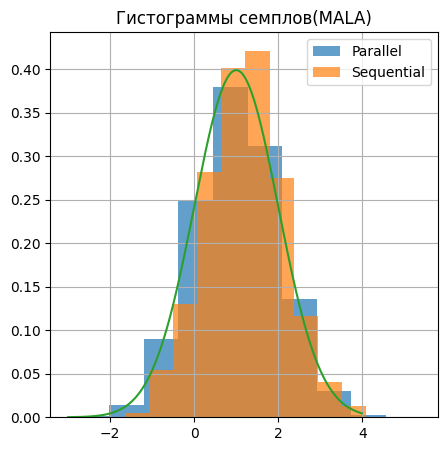

In [11]:
f, ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Гистограммы семплов(MALA)")
ax.hist(sampleParallel[:,0], alpha=0.7,density=True,)
ax.hist(sampleSequential[:,0], alpha=0.7,density=True)
ax.legend(["Parallel","Sequential"])

xx = np.arange(-3,4,0.01)
normPDF = spstats.norm.pdf(xx-1)
ax.plot(xx,normPDF)

Сходимость не зависит от того, с какого распределения мы стартовали. Давайте попробуем семплировать из такого же распределения, но запустим два варианта цепи (обе в режиме sequential): с началом в  $7$ и с началом в $-4$.

Нарисуйте ниже графики, где по оси х отложено время, а по оси y -- значения цепей. Не забуьте про $\texttt{burnIn}$.

In [12]:
#pass t because of solver
def gradLog(t,x):
    return -(x-1)
def density(x):
    return np.exp(-(x-1)**2/2).squeeze()

startSampler1 = ConstSampler(np.array([7]))
startSampler2 = ConstSampler(np.array([-5]))
delta = 0.01
malaSampler1 = MALASampler(gradLog,startSampler1,density,delta)
malaSampler2 = MALASampler(gradLog,startSampler2,density,delta)
ulaSampler1 = ULASampler(gradLog,startSampler1,delta)
ulaSampler2 = ULASampler(gradLog,startSampler2,delta)

In [13]:
experiments = {"MALA1": {"sampler":malaSampler1},
               "MALA2": {"sampler":malaSampler2},
               "ULA1": {"sampler":ulaSampler1},
               "ULA2": {"sampler":ulaSampler2}}
expResults = {expId: exp["sampler"].sample(10000,burnIn=1, parallelChains=False) for expId,exp in experiments.items()}

Burning...


100%|██████████| 1/1 [00:00<00:00, 1999.19it/s]


Sampling...


100%|██████████| 9999/9999 [00:00<00:00, 11043.20it/s]


Burning...


100%|██████████| 1/1 [00:00<00:00, 991.09it/s]


Sampling...


Burning: 100%|██████████| 1/1 [00:00<00:00, 967.77it/s]


Sampling...


Burning: 100%|██████████| 1/1 [00:00<?, ?it/s]


Sampling...


Sampling: 100%|██████████| 9999/9999 [00:00<00:00, 32330.88it/s]


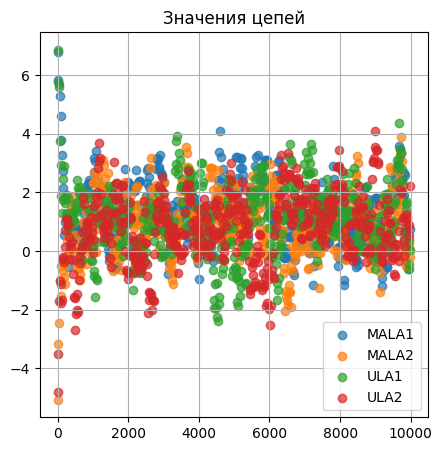

In [14]:
f, ax = plt.subplots(figsize=(5,5))

ax.grid()
ax.set_title("Значения цепей")

expKeys = list(experiments.keys())
for key in expKeys:
    ax.scatter(np.arange(expResults[key].shape[0])[::20],expResults[key].squeeze()[::20],alpha=0.7)

ax.legend(expKeys)

MALA мало смысла запускать с плохого старта из региона с низкой плотностью, потому что мы часто будем отклонять семпл. Поэтому если алгоритм не сходится, всегда можно начать с ULA.

## Плотность посложнее (15 баллов)

Рассмотрим диффузию в $\mathbb{R}^2$

$$
dX_t = b(X_t)dt + \sqrt{2} dW_t, \quad b(x,y) = -0.5[x/250 + 8x(y+2x^2-10), ~ 2(y+2x^2-10) ]^T
$$

Вычислите стационарную плотность этой диффузии.

РЕШЕНИЕ ЗДЕСЬ


Из уравнения Фоккера-Планка:
$$
\nabla \log \pi(x, y) = b(x, y)
$$

Посчитаем производные:
$$
    \partial_y\ln\pi = -y - 2x^2 + 10
    \Rightarrow
    \ln\pi = -\frac{y^2}{2} - 2x^2y + 10y + f(x).
$$

$$
    \partial_x\ln\pi
    = -\frac{x}{500} -4x(y+2x^2-10)
    \Rightarrow
    f'(x) = -8x^3 + 40x - \frac{x}{500},
$$
$$
    f(x) = -2x^4 + 20x^2 - \frac{x^2}{1000} + \text{const}.
$$

Объединим результаты:

$$
\ln\pi = -\frac{y^2}{2} - 2x^2y + 10y - 2x^4 + 20x^2 - \frac{x^2}{1000} + \text{const}
$$

$$\Downarrow$$

$$
\pi(x, y) = \frac{1}{z}\exp{\left(-\frac{x^2}{1000} - 2x^4 +20x^2 - \frac{(y+2x^2-10)^2}{2} \right)}
$$
z обеспечивает условие, что интеграл вероятности по всей области равен 1

### (5 баллов) Семплирование

Постройте семплы спомощью алгоритмов MALA и ULA из начального распределения, которое вам кажется удобнее, обоснуйте свой выбор.

Запустите параллельно $1000$ цепей для каждого алгоритма и нарисуйте на плоскости их положения в разные моменты времени $t=1,1000,10000,100000$(вам поможет реинициализация с помощью ConstExactSampler). Когда примерно цепь доходит до эргодического состояния? Попробуйте разные размеры шага $\texttt{delta}=0.01,0.1,0.001$, как изменятся результаты работы алгоритма? Для стартового разогрева можно использовать ULA, если в MALA много отвержений, а потом перейти на MALA.

In [ ]:
#pass t because of solver
def gradLog(t,x):
    res = np.zeros_like(x)
    x, y = x[:, 0], x[:, 1]
    res[:, 0] = -(x / 500 + 4 * x * (y + 2 * x**2 - 10))
    res[:, 1] = -(y + 2 * x**2 - 10)
    return res

def logDensity(x):
    x, y = x[:, 0], x[:, 1]
    return -(x**2)*1e-3 - 0.5*((y + 2 * x**2 - 8)**2)

startSampler = GaussianSampler(np.zeros([2])+4,np.array([[1,0],[0,1]]))
delta = 0.1
ulaSampler00 = ULASampler(gradLog,startSampler,delta)

In [16]:
class ConstExactSampler(Sampler):
    
    def __init__(self, x):
        self.x = x
        
    def sample(self,N):
        return self.x
    
#dummy thing for checkpointing

In [17]:
num_simulations = 1000
step_sizes = [1e-1, 1e-2, 1e-3]
burn_in_periods = [1, 1000, 10000, 100000]
simulation_results = {}

for step_size in step_sizes:
    for burn_in in burn_in_periods:
        starting_points = np.array([[x, -2*x**2 + 10] for x in np.linspace(-3, 3, num_simulations)])
        initial_sampler = ConstExactSampler(starting_points)
        ula_algorithm = ULASampler(gradLog, initial_sampler, step_size)
        mala_algorithm = MALASampler(gradLog, initial_sampler, logDensity, step_size)
        
        print(f'Step size: {step_size}, Burn-in: {burn_in}')
        simulation_results[("ULA", step_size, burn_in)] = ula_algorithm.sample(num_simulations, burnIn=burn_in, parallelChains=True)
        simulation_results[("MALA", step_size, burn_in)] = mala_algorithm.sample(num_simulations, burnIn=burn_in, parallelChains=True)

Step size: 0.1, Burn-in: 1
Sampling...


100%|██████████| 1/1 [00:00<?, ?it/s]


Burning...


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\79636\AppData\Local\Temp\ipykernel_26104\1831758831.py:67: RuntimeWarning: invalid value encountered in log
  log_F = np.log(self.density(x))
C:\Users\79636\AppData\Local\Temp\ipykernel_26104\1831758831.py:68: RuntimeWarning: invalid value encountered in log
  log_Fnew = np.log(self.density(xNew))
100%|██████████| 1/1 [00:00<00:00, 502.25it/s]


Sampling...
Step size: 0.1, Burn-in: 1000
Sampling...


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\79636\AppData\Local\Temp\ipykernel_26104\133393012.py:6: RuntimeWarning: overflow encountered in multiply
  res[:, 0] = -(x / 500 + 4 * x * (y + 2 * x**2 - 10))
C:\Users\79636\AppData\Local\Temp\ipykernel_26104\133393012.py:6: RuntimeWarning: overflow encountered in square
  res[:, 0] = -(x / 500 + 4 * x * (y + 2 * x**2 - 10))
C:\Users\79636\AppData\Local\Temp\ipykernel_26104\133393012.py:7: RuntimeWarning: overflow encountered in square
  res[:, 1] = -(y + 2 * x**2 - 10)
C:\Users\79636\AppData\Local\Temp\ipykernel_26104\133393012.py:7: RuntimeWarning: overflow encountered in multiply
  res[:, 1] = -(y + 2 * x**2 - 10)
C:\Users\79636\AppData\Local\Temp\ipykernel_26104\3824205337.py:74: RuntimeWarning: invalid value encountered in add
  res = x + drift * dt + (diffusion * dw).sum(axis=-1)
C:\Users\79636\AppData\Local\Temp\ipykernel_26104\133393012.py:6: RuntimeWarning: invalid value encountered in add
  res[:, 0] = -(x / 500 + 4 * x * (y 

Burning...


100%|██████████| 1000/1000 [00:00<00:00, 1961.83it/s]


Sampling...
Step size: 0.1, Burn-in: 10000
Sampling...


100%|██████████| 10000/10000 [00:01<00:00, 7167.67it/s]


Burning...


100%|██████████| 10000/10000 [00:04<00:00, 2366.42it/s]


Sampling...
Step size: 0.1, Burn-in: 100000
Sampling...


100%|██████████| 100000/100000 [00:13<00:00, 7355.32it/s]


Burning...


100%|██████████| 100000/100000 [00:41<00:00, 2384.12it/s]


Sampling...
Step size: 0.01, Burn-in: 1
Sampling...


100%|██████████| 1/1 [00:00<?, ?it/s]


Burning...


100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Sampling...
Step size: 0.01, Burn-in: 1000
Sampling...


100%|██████████| 1000/1000 [00:00<00:00, 7814.10it/s]


Burning...


100%|██████████| 1000/1000 [00:00<00:00, 2478.90it/s]


Sampling...
Step size: 0.01, Burn-in: 10000
Sampling...


100%|██████████| 10000/10000 [00:01<00:00, 7210.62it/s]


Burning...


100%|██████████| 10000/10000 [00:04<00:00, 2006.65it/s]


Sampling...
Step size: 0.01, Burn-in: 100000
Sampling...


100%|██████████| 100000/100000 [00:22<00:00, 4354.77it/s]


Burning...


100%|██████████| 100000/100000 [01:06<00:00, 1496.19it/s]


Sampling...
Step size: 0.001, Burn-in: 1
Sampling...


100%|██████████| 1/1 [00:00<00:00, 586.78it/s]


Burning...


100%|██████████| 1/1 [00:00<00:00, 997.22it/s]


Sampling...
Step size: 0.001, Burn-in: 1000
Sampling...


100%|██████████| 1000/1000 [00:00<00:00, 4936.71it/s]


Burning...


100%|██████████| 1000/1000 [00:00<00:00, 1271.80it/s]


Sampling...
Step size: 0.001, Burn-in: 10000
Sampling...


100%|██████████| 10000/10000 [00:02<00:00, 4740.90it/s]


Burning...


100%|██████████| 10000/10000 [00:05<00:00, 1771.73it/s]


Sampling...
Step size: 0.001, Burn-in: 100000
Sampling...


100%|██████████| 100000/100000 [00:15<00:00, 6336.16it/s]


Burning...


100%|██████████| 100000/100000 [00:43<00:00, 2282.43it/s]

Sampling...


Визуализация:

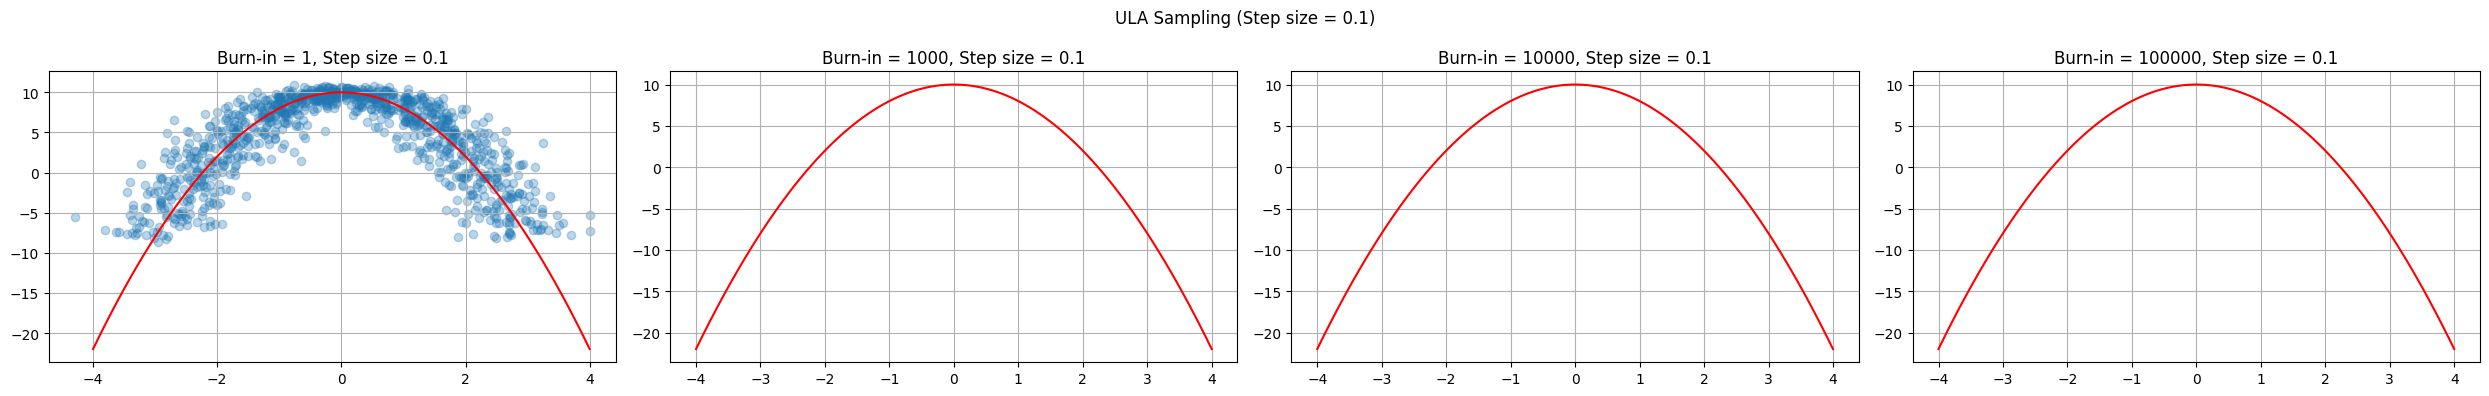

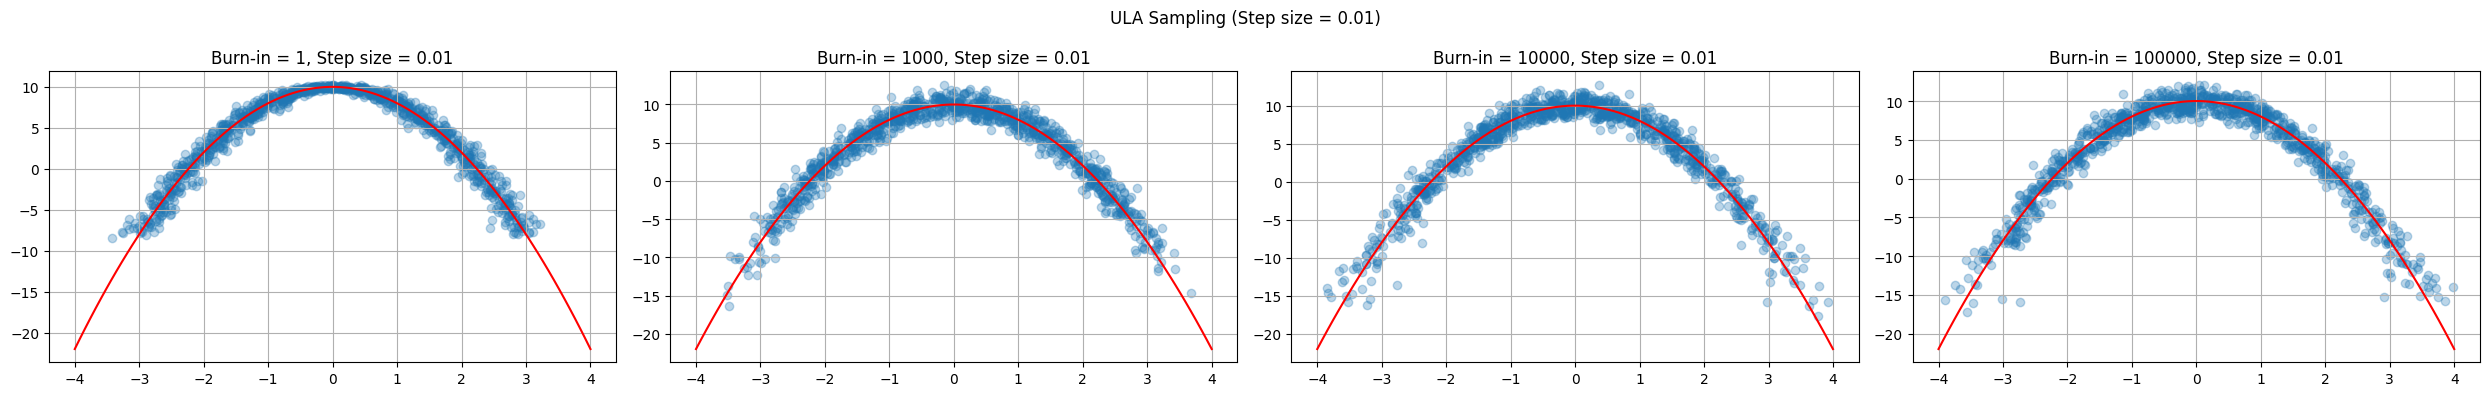

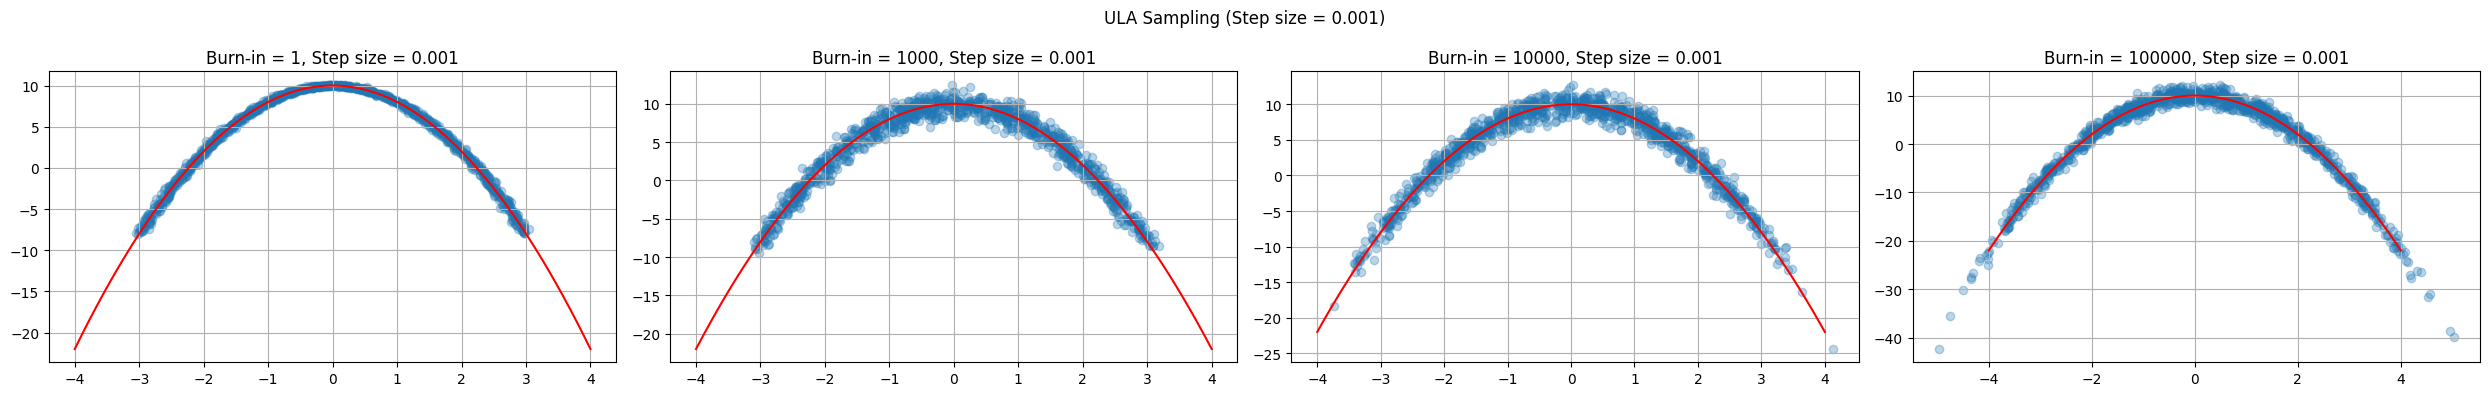

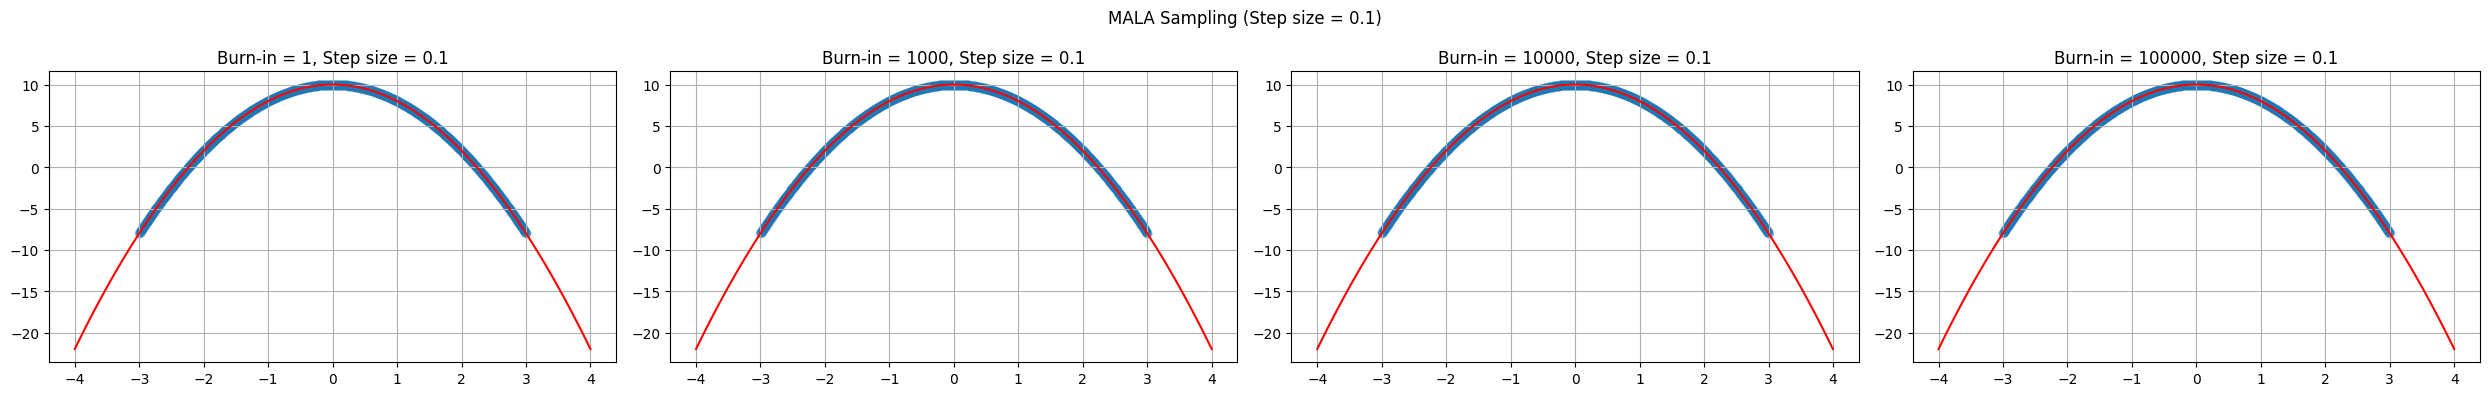

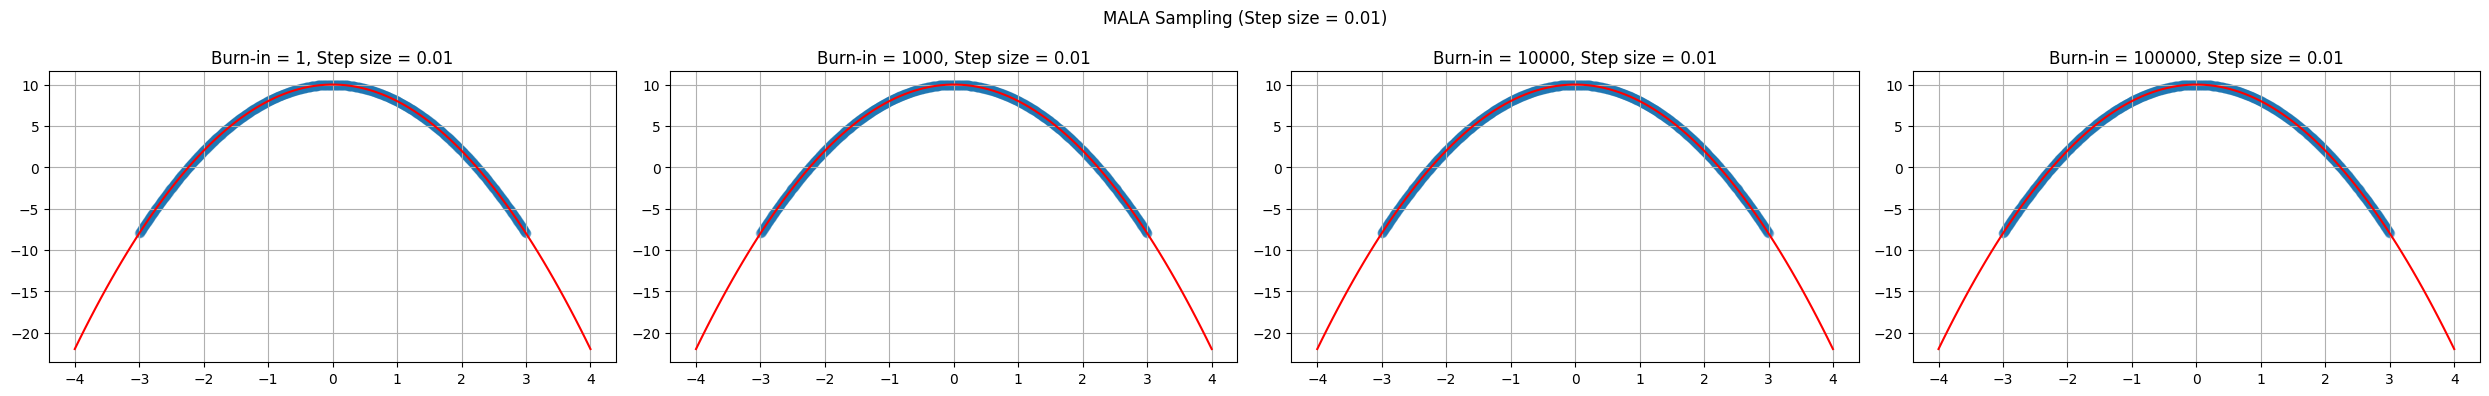

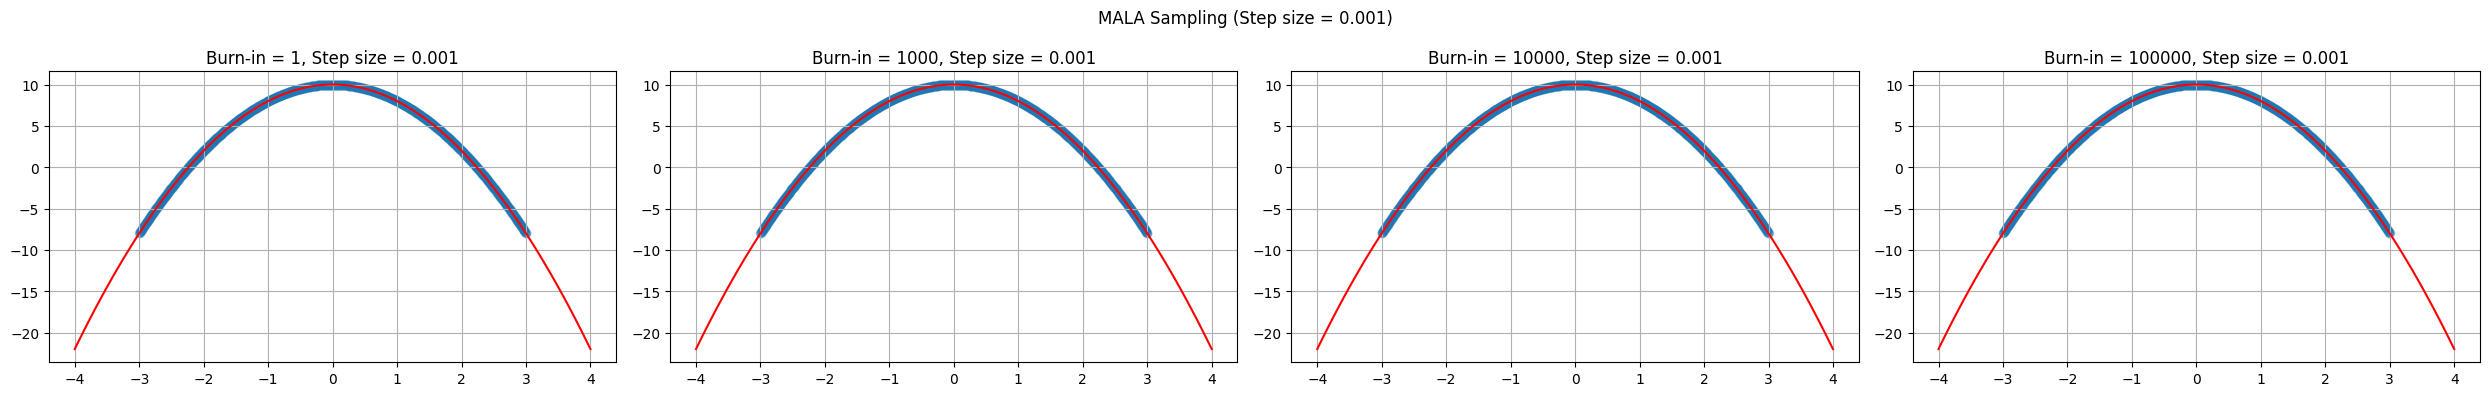

In [ ]:
num_simulations = 1000
step_sizes = [1e-1, 1e-2, 1e-3]
burn_in_periods = [1, 1000, 10000, 100000]
sampling_methods = ['ULA', 'MALA']

for method in sampling_methods:
    for step_size in step_sizes:
        samples_list = [
            simulation_results[(method, step_size, burn_in)]
            for burn_in in burn_in_periods
        ]
        
        fig, axes = plt.subplots(1, 4, figsize=(25, 4))
        
        for i, (samples, burn_in) in enumerate(zip(samples_list, burn_in_periods)):
            ax = axes[i]
            ax.grid()
            ax.scatter(samples[:, 0], samples[:, 1], alpha=0.3)
            ax.set_title(f"Burn-in = {burn_in}, Step size = {step_size}")
            
            x_values = np.linspace(-4, 4, 100)
            ax.plot(x_values, -2 * x_values**2 + 10, color='red')
        
        plt.suptitle(f"{method} Sampling (Step size = {step_size})")
        plt.tight_layout()
        plt.show()

При семплировании MALA обеспечивает более точное соответствие выборок целевому распределению 